In [1]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from utils import utils, torch_utils

from config import init_args
import data
import models
import librosa
import copy

import json
from moviepy.editor import VideoFileClip
import argparse
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, average_precision_score, precision_recall_curve

In [2]:
args = init_args()

train_dataset = data.GreatestHitDataset(args, split='train')
train_loader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False)

val_dataset = data.GreatestHitDataset(args, split='val')
val_loader = DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False)

test_dataset = data.GreatestHitDataset(args, split='test')
test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=args.num_workers,
    pin_memory=True,
    drop_last=False)

Removed samples (less than 150.0 frames) : 14
Greatesthit Dataloader: # sample of train: 32752
Removed samples (less than 150.0 frames) : 5
Greatesthit Dataloader: # sample of val: 1926
Removed samples (less than 150.0 frames) : 0
Greatesthit Dataloader: # sample of test: 4041


In [4]:
train_dataset.list_discard

['2015-09-27-22-43-25-429_56595',
 '2015-09-27-22-43-25-429_128624',
 '2015-10-06-18-02-12-315_33075',
 '2015-10-06-18-02-12-315_59535',
 '2015-10-06-18-02-12-315_19844',
 '2015-09-27-22-43-25-429_140385',
 '2015-09-27-22-43-25-429_105105',
 '2015-10-06-18-02-12-315_93344',
 '2015-09-27-22-43-25-429_83055',
 '2015-10-06-18-02-12-315_69825',
 '2015-10-06-18-02-12-315_108045',
 '2015-09-27-22-43-25-429_69825',
 '2015-09-27-22-43-25-429_94815',
 '2015-09-27-22-43-25-429_19844']

In [6]:
val_dataset.list_discard

['2015-09-27-22-43-25-429_44834',
 '2015-09-27-22-43-25-429_116865',
 '2015-09-27-22-43-25-429_31604',
 '2015-10-06-18-02-12-315_46305',
 '2015-10-06-18-02-12-315_83055']

In [3]:
test_dataset.list_discard

[]

In [17]:
print("Train dataset available: ", len(train_dataset.list_sample))
print("Train dataset unavailable: ", len(train_dataset.list_discard))
print("Val dataset available: ", len(val_dataset.list_sample))
print("Val dataset unavailable: ", len(val_dataset.list_discard))
print("Test dataset available: ", len(test_dataset.list_sample))
print("Test dataset unavailable: ", len(test_dataset.list_discard))

Train dataset available:  32738
Train dataset unavailable:  14
Val dataset available:  1921
Val dataset unavailable:  5
Test dataset available:  4041
Test dataset unavailable:  0


In [14]:
train_avail_list = list(set([sample.split('_')[0] for sample in train_dataset.list_sample]))
train_unavail_list = list(set([sample.split('_')[0] for sample in train_dataset.list_discard]))
val_avail_list = list(set([sample.split('_')[0] for sample in val_dataset.list_sample]))
val_unavail_list = list(set([sample.split('_')[0] for sample in val_dataset.list_discard]))
test_avail_list = list(set([sample.split('_')[0] for sample in test_dataset.list_sample]))
test_unavail_list = list(set([sample.split('_')[0] for sample in test_dataset.list_discard]))

print("train dataset available: ", len(train_avail_list))
print("train dataset unavailable: ", len(train_unavail_list))
print("val dataset available: ", len(val_avail_list))
print("val dataset unavailable: ", len(val_unavail_list))
print("test dataset available: ", len(test_avail_list))
print("test dataset unavailable: ", len(test_unavail_list))

train dataset available:  871
train dataset unavailable:  2
val dataset available:  747
val dataset unavailable:  2
test dataset available:  97
test dataset unavailable:  0


In [16]:
print("train dataset unavailable: ", train_unavail_list)
print("val dataset unavailable: ", val_unavail_list)
print("test dataset unavailable: ", test_unavail_list)

train dataset unavailable:  ['2015-09-27-22-43-25-429', '2015-10-06-18-02-12-315']
val dataset unavailable:  ['2015-09-27-22-43-25-429', '2015-10-06-18-02-12-315']
test dataset unavailable:  []


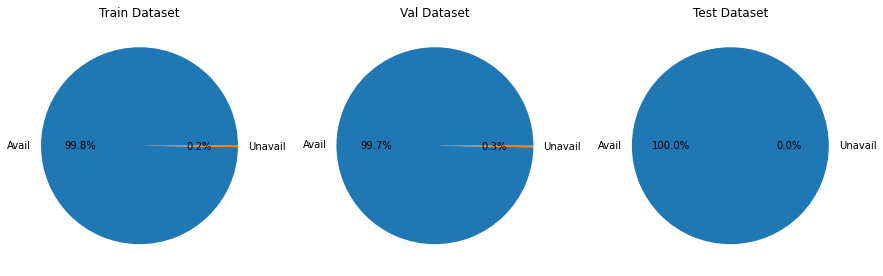

In [15]:
# visualize avaliable and unavailable data with pie chart
fig, axs = plt.subplots(1, 3, figsize=(15, 5), facecolor='w', edgecolor='k')
axs[0].pie([len(train_avail_list), len(train_unavail_list)], labels=['Avail', 'Unavail'], autopct='%1.1f%%')
axs[0].set_title('Train Dataset')
axs[1].pie([len(val_avail_list), len(val_unavail_list)], labels=['Avail', 'Unavail'], autopct='%1.1f%%')
axs[1].set_title('Val Dataset')
axs[2].pie([len(test_avail_list), len(test_unavail_list)], labels=['Avail', 'Unavail'], autopct='%1.1f%%')
axs[2].set_title('Test Dataset')
plt.show()

In [29]:
train_list_sample = '/home/dabin/video2foley/CondFoleyGen/data/greatesthit_train_2.00.json'
val_list_sample = '/home/dabin/video2foley/CondFoleyGen/data/greatesthit_val_2.00.json'
test_list_sample = '/home/dabin/video2foley/CondFoleyGen/data/greatesthit_test_2.00.json'

if isinstance(train_list_sample, str):
    with open(train_list_sample, "r") as f:
        train_list_sample = json.load(f)
if isinstance(val_list_sample, str):
    with open(val_list_sample, "r") as f:
        val_list_sample = json.load(f)
if isinstance(test_list_sample, str):
    with open(test_list_sample, "r") as f:
        test_list_sample = json.load(f)

In [30]:
train_list_video = list(set([sample.split('_')[0] for sample in train_list_sample]))
val_list_video = list(set([sample.split('_')[0] for sample in val_list_sample]))
test_list_video = list(set([sample.split('_')[0] for sample in test_list_sample]))

In [31]:
print("train_list_video: ", len(train_list_video))
print("val_list_video: ", len(val_list_video))
print("test_list_video: ", len(test_list_video))

train_list_video:  873
val_list_video:  749
test_list_video:  97


In [40]:
duplicated_A = []
for video in train_list_video:
    if video in val_list_video:
        duplicated_A.append(video)
        # print(video)
        
print("Duplicated A: ", len(duplicated_A))

Duplicated A:  749


In [41]:
duplicated_B = []
for video in train_list_video:
    if video in test_list_video:
        duplicated_A.append(video)
        # print(video)
        
print("Duplicated B: ", len(duplicated_B))

Duplicated B:  0


In [42]:
duplicated_C = []
for video in val_list_video:
    if video in test_list_video:
        duplicated_A.append(video)
        # print(video)
        
print("Duplicated C: ", len(duplicated_C))

Duplicated C:  0
